# Goal

The goal of this notebook is to help in interactively developing the new multi-objective version of the Tomograph.

## Goals for the Tomograph

1. Move away from matplotlib to either plotly, or bokeh. 
2. Make sure that:
    1. All scales are the same so that they are comparable.
    2. We should be able to plot not just predictions but also individual observations as a scatterplot. 
    3. We should be able to link the points across multiple charts to investigate them more deeply (bokeh seems to be the winner here)
    4. We should be able to connect multiple tomographs to the same optimizer, as any given analysis might focus on different aspects and each aspect should have it's own graphs.
3. The Tomograph produces a set of heatmaps that belong to 2D cross-sections of the higher-dimensional hypercube. All these cross-sections share a single point (often the optimum). The user should be able to:
    1. Select one of the predefined points (different types of optima, maybe optima for different contexts)
    2. View the resulting cross sections and sensitivity analysis for such a point
    3. Be able to use sliders to adjust the point so that they can easily "walk the hypercube"
    

Plotly has the advantage of also enabling 3D visualizations of the pareto frontier and generates surface plots etc. But bokeh has built-in support for linking data. 

Given what we need, I would start with bokeh, for dabl-style and tomograph plots, and then switch to plotly for parameter interactions, and 3D pareto visualizations.

https://docs.bokeh.org/en/latest/index.html

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory, objective_function_config_store
objective_function_config_store.list_named_configs()

[Name: default
 
 Description: None
 
 Config Values: {
   "implementation": "Hypersphere",
   "hypersphere_config.num_objectives": 3,
   "hypersphere_config.minimize": "all",
   "hypersphere_config.radius": 10,
   "description": "default"
 },
 Name: three_level_quadratic
 
 Description: None
 
 Config Values: {
   "implementation": "ThreeLevelQuadratic"
 },
 Name: flower
 
 Description: None
 
 Config Values: {
   "implementation": "Flower"
 },
 Name: noisy_polynomial_objective
 
 Description: None
 
 Config Values: {
   "implementation": "PolynomialObjective",
   "polynomial_objective_config.seed": 17,
   "polynomial_objective_config.input_domain_dimension": 2,
   "polynomial_objective_config.input_domain_min": -1024,
   "polynomial_objective_config.input_domain_width": 2048,
   "polynomial_objective_config.max_degree": 2,
   "polynomial_objective_config.include_mixed_coefficients": true,
   "polynomial_objective_config.percent_coefficients_zeroed": 0,
   "polynomial_objective_config

In [3]:
#objective_function_config = objective_function_config_store.get_config_by_name("multi_objective_2_mutually_exclusive_polynomials")
objective_function_config = objective_function_config_store.get_config_by_name("three_level_quadratic")
#objective_function_config = objective_function_config_store.get_config_by_name("2d_hypersphere_minimize_none")

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)
optimization_problem = objective_function.default_optimization_problem

In [4]:
print(objective_function.default_optimization_problem)

Parameter Space:
  Name: three_level_quadratic_config
  Dimensions:
    vertex_height: {low, 5, 15}

  IF vertex_height IN {low} THEN (
    Name: low_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {15} THEN (
    Name: high_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {5} THEN (
    Name: medium_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )
------------------------------------------------------------
Context Space:
None
------------------------------------------------------------
Feature Space:
  Name: features
  Dimensions:
    contains_context: {False}

  IF contains_context IN {False} THEN (
    Name: three_level_quadratic_config
    Dimensions:
      vertex_height: {low, 5, 15}

    IF vertex_height IN {low} THEN (
      Name: low_quadratic_params
      Dimensions:
        x_1: [-100.00, 100.

In [5]:
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory, bayesian_optimizer_config_store
optimizer_factory = BayesianOptimizerFactory()
optimizer_config = bayesian_optimizer_config_store.default
optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=optimizer_config,
    optimization_problem=optimization_problem
)

03/12/2021 00:30:37 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.7,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_m

In [6]:
params_df = objective_function.parameter_space.random_dataframe(num_samples=2000)
objectives_df = objective_function.evaluate_dataframe(params_df)

In [7]:
optimizer.register(parameter_values_pandas_frame=params_df, target_values_pandas_frame=objectives_df)

03/12/2021 00:30:37 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 153 -                  register() ] Registering 2000 parameters and 2000 objectives.


In [8]:
from mlos.Spaces import Point
from mlos.OptimizerMonitoring.Tomograph.ModelTomograph import ModelTomograph

tomograph = ModelTomograph(optimizer=optimizer)

In [9]:
config = objective_function.parameter_space.random()

In [10]:
import os
os.getpid()

870752

{
  "vertex_height": "low",
  "low_quadratic_params.x_1": -9.995139669011621,
  "low_quadratic_params.x_2": 70.7390440521047
}


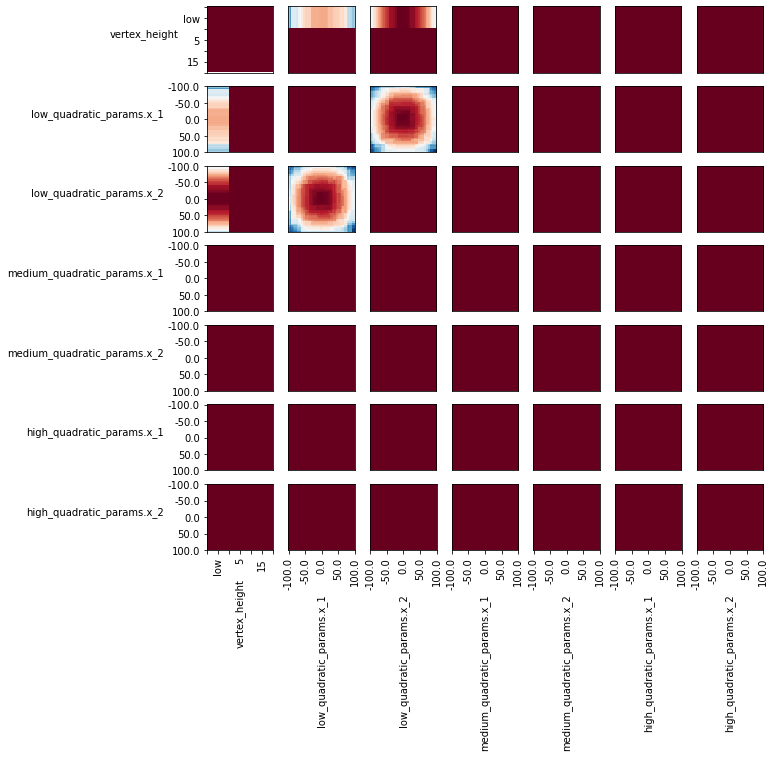

In [11]:
tomograph.plot()

## Plotting Observations
The goal of this next section is to plot all observations on a grid where:
   1. On the diagonal we plot a single parameters vs. objective value (basically what dabl does already)
   2. On the other subgraphs we plot two parameters colored according to the objective function value. Additionally, we can also regulate their opacity as a function of their distance from the plane of the graph.

In [70]:
from typing import List

from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import CategoricalTicker, ColorBar, ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure
from bokeh.transform import factor_mark

import pandas as pd

from mlos.Logger import create_logger
from mlos.Optimizers.OptimizationProblem import OptimizationProblem
from mlos.Optimizers.OptimizerBase import OptimizerBase
from mlos.Spaces import CategoricalDimension, Point
from mlos.Spaces.HypergridAdapters import CategoricalToDiscreteHypergridAdapter
from mlos.Utils.KeyOrderedDict import KeyOrderedDict


class GridPlot:
    """Maintains all data, meta-data and styling information required to produce a grid-plot.

    The grid plot is built based on the OptimizationProblem instance, to find out what objectives and what
    features are to be plotted. We use information contained in the dimensions to compute the ranges for all
    axes/ranges on the plot, as well as to configure the color map.

    If the range is infinite (as can be the case with many objectives) we can use the observed range of values to
    configure the range of values to be plotted.

    Each figure in the grid plot contains:
    * Either a scatter plot of feature vs. feature where the color of each point corresponds to the value of the objective value
    * Or a scatter plot of feature vs. objective (if we are on a diagonal).

    Additionally, as an extension, we could also plot the predicted values as a background heatmap for the feature vs. feature
    plots, and a predicted value with confident intervals plot for feature vs. objective plots. This of course introduces a complication
    of needing to query the optimizer for each pixel and so we will add it later.
    """

    def __init__(
        self,
        optimization_problem: OptimizationProblem,
        objective_name: str,
        logger=None
    ):
        if logger is None:
            logger = create_logger(self.__class__.__name__)
        self.logger = logger
        
        
        # Let's start with the data section. This will be populated by the Tomograph.
        #
        self._observations_df = None
        
        #  Metatdata - what dimensions are we going to be plotting here?
        #
        self.optimization_problem = optimization_problem
        assert objective_name in self.optimization_problem.objective_names
        self.objective_name = objective_name

        
        self._feature_space_adapter = CategoricalToDiscreteHypergridAdapter(adaptee=self.optimization_problem.feature_space)

        self.feature_dimension_names: List[str] = [
            feature_name
            for feature_name
            in self._feature_space_adapter.dimension_names
            if feature_name != "contains_context"
        ]
        self.num_features = len(self.feature_dimension_names)

        # Finally, below is all the data and objects that bokeh needs to render this grid plot.
        #
            
        
        # Plot options including tooltips.
        #
        

        # Stores figure ranges by name so that we can synchronize zooming and panning
        #
        self._x_ranges_by_name = {}
        self._y_ranges_by_name = {}

        # Stores an array of all plots for all objectives.
        #
        self._figures = [
            [None for col in range(self.num_features)]
            for row in range(self.num_features)
        ]
        

        # Stores the bokeh gridplot object.
        #
        self._grid_plot = None
        self._data_source = None
        self._pareto_data_source = None
        self._dominated_data_source = None
        
    @property
    def grid_plot(self):
        return self._grid_plot

        
    def update_observations(self, observations_df: pd.DataFrame):
        """Updates the plot with new observations.
        """
        
        self._observations_df = observations_df
        self._data_source = ColumnDataSource(data=self._observations_df)
        self._pareto_data_source = ColumnDataSource(data=self._observations_df[self._observations_df['is_pareto']])
        self._dominated_data_source = ColumnDataSource(data=self._observations_df[~self._observations_df['is_pareto']])
        assert self._observations_df is not None and len(self._observations_df.index) > 0
        
        self._x_ranges_by_name = {}
        self._y_ranges_by_name = {}
        self._grid_plot = None
        
        
        tooltips = [(f"{feature_name}", f"@{feature_name}") for feature_name in self.feature_dimension_names]
        tooltips.extend([(f"{objective_name}", f"@{objective_name}") for objective_name in self.optimization_problem.objective_names])
        hover = HoverTool(tooltips=tooltips)
        
        plot_options = dict(
            plot_width=int(2000 / self.num_features),
            plot_height=int(2000 / self.num_features),
            tools=['pan','wheel_zoom','box_select','lasso_select','reset', hover]
        )
        
        final_column_plot_options = dict(
            plot_width=int(2000 / self.num_features) + 75,
            plot_height=int(2000 / self.num_features),
            tools=['pan','wheel_zoom','box_select','lasso_select','reset', hover]
        )
        
        color_mapper = LinearColorMapper(palette='Turbo256', low=self._observations_df[self.objective_name].min(), high=self._observations_df[self.objective_name].max())

        for row, row_dimension_name in enumerate(self.feature_dimension_names):
            for col, col_dimension_name in enumerate(self.feature_dimension_names):

                x_axis_name = col_dimension_name
                x_ticks, x_tick_label_mapping = self._get_feature_ticks_and_tick_label_mapping(x_axis_name)

                if row == col:
                    # For plots on the diagonals, we want to plot the row dimension vs. objective
                    #
                    y_axis_name = self.objective_name
                    y_ticks, y_tick_label_mapping = None, None
                else:
                    y_axis_name = row_dimension_name
                    y_ticks, y_tick_label_mapping = self._get_feature_ticks_and_tick_label_mapping(y_axis_name)
                    
                
                if col == (self.num_features - 1):
                    print(f"Final column! {final_column_plot_options}")
                    fig = figure(**final_column_plot_options)
                else:
                    fig = figure(**plot_options)

                fig.scatter(
                    x_axis_name,
                    y_axis_name,
                    color={'field': self.objective_name, 'transform': color_mapper},
                    marker='circle',
                    source=self._dominated_data_source,
                    legend_label="dominated",
                    muted_alpha=0.02 # TODO: figure out how to have clicking on the legend mute unselected points.
                )
                
                fig.scatter(
                    x_axis_name,
                    y_axis_name,
                    color={'field': self.objective_name, 'transform': color_mapper},
                    marker='triangle',
                    source=self._pareto_data_source,
                    legend_label="pareto optimal",
                    muted_alpha=0.02 # TODO: figure out how to have clicking on the legend mute unselected points.
                )
                
                fig.legend.click_policy="hide"
                fig.xaxis.axis_label = x_axis_name
                fig.yaxis.axis_label = y_axis_name


                fig.xaxis.ticker = x_ticks
                fig.axis.major_label_overrides = x_tick_label_mapping

                if y_ticks is not None:
                    fig.yaxis.ticker = y_ticks
                    fig.yaxis.major_label_overrides = y_tick_label_mapping

                self._set_ranges(fig, x_axis_name, y_axis_name)

                self.logger.debug(f"Assigning figure to [{row}][{col}]. {self.objective_name}, {row_dimension_name}, {col_dimension_name}")
                self._figures[row][col] = fig
            
            
            color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=self.objective_name)
            self._figures[row][-1].add_layout(color_bar, 'right')


        self._grid_plot = gridplot(self._figures)
        
        
    def _get_feature_ticks_and_tick_label_mapping(self, axis_name):
        projected_ticks = self._feature_space_adapter[axis_name].linspace(5)
        projected_ticks_df = pd.DataFrame({axis_name: projected_ticks})
        unprojected_ticks_df = self._feature_space_adapter.unproject_dataframe(projected_ticks_df)
        unprojected_col_name = unprojected_ticks_df.columns[0] 
        tick_mapping = {
            projected_tick: f"{unprojected_tick:.2f}" if isinstance(unprojected_tick, float) else str(unprojected_tick)
            for projected_tick, unprojected_tick
            in zip(projected_ticks, unprojected_ticks_df[unprojected_col_name])
        }
        return projected_ticks, tick_mapping
    

    def _set_ranges(self, fig, x_axis_name, y_axis_name):
        """Sets the ranges on each axis to enable synchronized panning and zooming."""
        x_range = self._x_ranges_by_name.get(x_axis_name, None)
        if x_axis_name in self._x_ranges_by_name:
            fig.x_range = self._x_ranges_by_name[x_axis_name]
        else:
            self._x_ranges_by_name[x_axis_name] = fig.x_range
        
        if y_axis_name in self._y_ranges_by_name:
            fig.y_range = self._y_ranges_by_name[y_axis_name]
        else:
            self._y_ranges_by_name[y_axis_name] = fig.y_range
        

In [71]:
class Tomograph2:
    """"""    
    
    
    def __init__(self, optimizer: OptimizerBase, logger=None):
        if logger is None:
            logger = create_logger(self.__class__.__name__)
        self.logger = logger
        
        self.optimizer = optimizer        
        self.optimization_problem = optimizer.optimization_problem

        self.grid_plots_by_objective_name = KeyOrderedDict(ordered_keys=self.optimization_problem.objective_names, value_type=GridPlot)
        
        for objective_name in self.optimization_problem.objective_names:
            self.grid_plots_by_objective_name[objective_name] = GridPlot(
                optimization_problem=self.optimization_problem,
                objective_name=objective_name,
                logger=self.logger
            )
        
        self._feature_space_adapter = CategoricalToDiscreteHypergridAdapter(adaptee=self.optimization_problem.feature_space)
        
        
    
    def plot_observations(self, objective_names: List[str] = None, refresh_data: bool = True):
        """Plot all observations.
        """
            
        self.logger.debug(f"Plotting observations")
        
        if objective_names is None:
            objective_names = [self.optimization_problem.objective_names[0]]
            
        if refresh_data:
            self._refresh_data()
        
        for objective_name in objective_names:
            grid_plot = self.grid_plots_by_objective_name[objective_name]
            grid_plot.update_observations(self._observations_df)
            show(grid_plot.grid_plot)        
        
        
    def _refresh_data(self):
        self.logger.debug(f"Refreshing data")
        params_df, objectives_df, context_df = self.optimizer.get_all_observations()
        features_df = self.optimization_problem.construct_feature_dataframe(parameters_df=params_df, context_df=context_df, product=False)
        projected_features_df = self._feature_space_adapter.project_dataframe(features_df)
        self._observations_df = pd.concat([projected_features_df, objectives_df], axis=1)
        pareto_df = self.optimizer.pareto_frontier.pareto_df
        self._observations_df['is_pareto'] = False
        self._observations_df.loc[pareto_df.index, 'is_pareto'] = True
        
        
    
    
    
    
        
output_notebook()       
tomograph2 = Tomograph2(optimizer=optimizer)
tomograph2.plot_observations()

Loading BokehJS ...

Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'wheel_zoom', 'box_select', 'lasso_select', 'reset', HoverTool(id='131826', ...)]}
Final column! {'plot_width': 360, 'plot_height': 285, 'tools': ['pan', 'whee